In [193]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c as C
plt.rcParams.update({"xtick.direction": "in", "ytick.direction": "in"})

In [194]:
def gaussian(x, center, FWHM, normalisation_coeffient = None):
    sigma = (8 *np.log(2))**-0.5 *FWHM
    exponent = -(1/2) *(x -center)**2 /(sigma**2)
    if normalisation_coeffient == None:
        normalisation_coeffient = 0.5/np.sum(np.abs(np.exp(exponent))) #1 /(sigma *(2*np.pi)**0.5)
        return normalisation_coeffient *np.exp(exponent), normalisation_coeffient
    else:
        return normalisation_coeffient *np.exp(exponent)

In [214]:
array_length = 53 #in pixels
pixel_pitch = 1000 #in um
central_freq = 0.45 #in THz
FWHM_freq = 0.5 #in THz
theta = 200 #in arcminutes
number_of_averages = 30 #Frames can be averaged to reduce noise during pre or post-processing. Will allow us to measure the variance.

In [215]:
central_wavenumber = 2*np.sin(np.deg2rad(theta/60)) *(central_freq*1e12) /C #periodicity of the fringes as it appears on the camera in m^-1
FWHM_wavenumber = 2*np.sin(np.deg2rad(theta/60)) *(FWHM_freq*1e12) /C # in m^-1

print(1/central_wavenumber/(pixel_pitch*1e-6)) # effective wavelength in pixels


5.728845322152057


In [216]:
central_wavenumber

174.55524521376802

In [218]:
####### CREATE GAUSSIAN FREQUENCIES ###########

wavenumbers = np.fft.rfftfreq(array_length, (pixel_pitch*1e-6))
freqs = C *wavenumbers /(2*np.sin(np.deg2rad(theta/60))) *1e-12 #in THz
amplitudes, normalisation_coeffient = gaussian(wavenumbers, central_wavenumber, FWHM_wavenumber)
#amplitudes = phase *amplitudes
intensity = np.fft.irfft(amplitudes, norm= "forward", n= array_length)

oversampled_wn = np.fft.rfftfreq(array_length *10, (pixel_pitch*1e-6))
oversampled_freqs = C *oversampled_wn /(2*np.sin(np.deg2rad(theta/60))) *1e-12 #in THz
oversampled_amps = gaussian(oversampled_wn, central_wavenumber, FWHM_wavenumber, normalisation_coeffient= normalisation_coeffient)


displacement = [n *pixel_pitch*1e-3 for n in range(array_length)]
displacement = np.array(displacement) - (pixel_pitch*1e-3* array_length//2)
intensity = np.exp(-4 *np.log(2) *displacement**2 *35**-2) *(np.cos(2*np.pi*104.73*displacement) +np.cos(2*np.pi*174.56*displacement))
amplitudes = np.fft.rfft(intensity, norm= "forward")


In [219]:
####### ADD NOISE DUE TO VIBRATIONS ########
vibration_uncertainty = 0 #mm. uncertainty of the position of the peak due to vibrations.

temporal_sigma = vibration_uncertainty*1e-3 *2*np.sin(np.deg2rad(theta/60)) /C # convert to s.
noise = np.random.normal(0, temporal_sigma, number_of_averages)

vibration_amps = np.repeat(amplitudes[None, :], number_of_averages, axis= 0)
vibration_amps = (vibration_amps *np.exp(1j *freqs[None, :]*1e12 *noise[:, None]))

In [220]:
####### IFFT TO MAKE INTERFEROGRAMS ###########

vibration_intensity = np.fft.irfft(vibration_amps, norm= "forward", axis= 1, n= array_length)

In [221]:
####### ADD READ NOISE ########

read_noise_sigma = 0.2

noise = np.random.normal(0, read_noise_sigma, (number_of_averages, array_length))
noisy_intensity = vibration_intensity +noise
noisy_amps = np.fft.rfft(noisy_intensity, norm= "forward", axis= 1)


In [222]:
########## 'TEMPORAL' AVERAGE ############

uncertainty = np.std(noisy_intensity, axis= 0)
averaged_intensity = np.mean(noisy_intensity, axis= 0)

averaged_amps = np.fft.rfft(averaged_intensity, norm= "forward")

In [223]:
########## SHIFT ALL INTERFEROGRAMS AROUND 0 ############

#intensity = np.fft.fftshift(intensity)
#vibration_intensity = np.fft.fftshift(vibration_intensity, axes= 1)
#noisy_intensity = np.fft.fftshift(noisy_intensity, axes= 1)
#averaged_intensity = np.fft.fftshift(averaged_intensity)
#uncertainty = np.fft.fftshift(uncertainty)


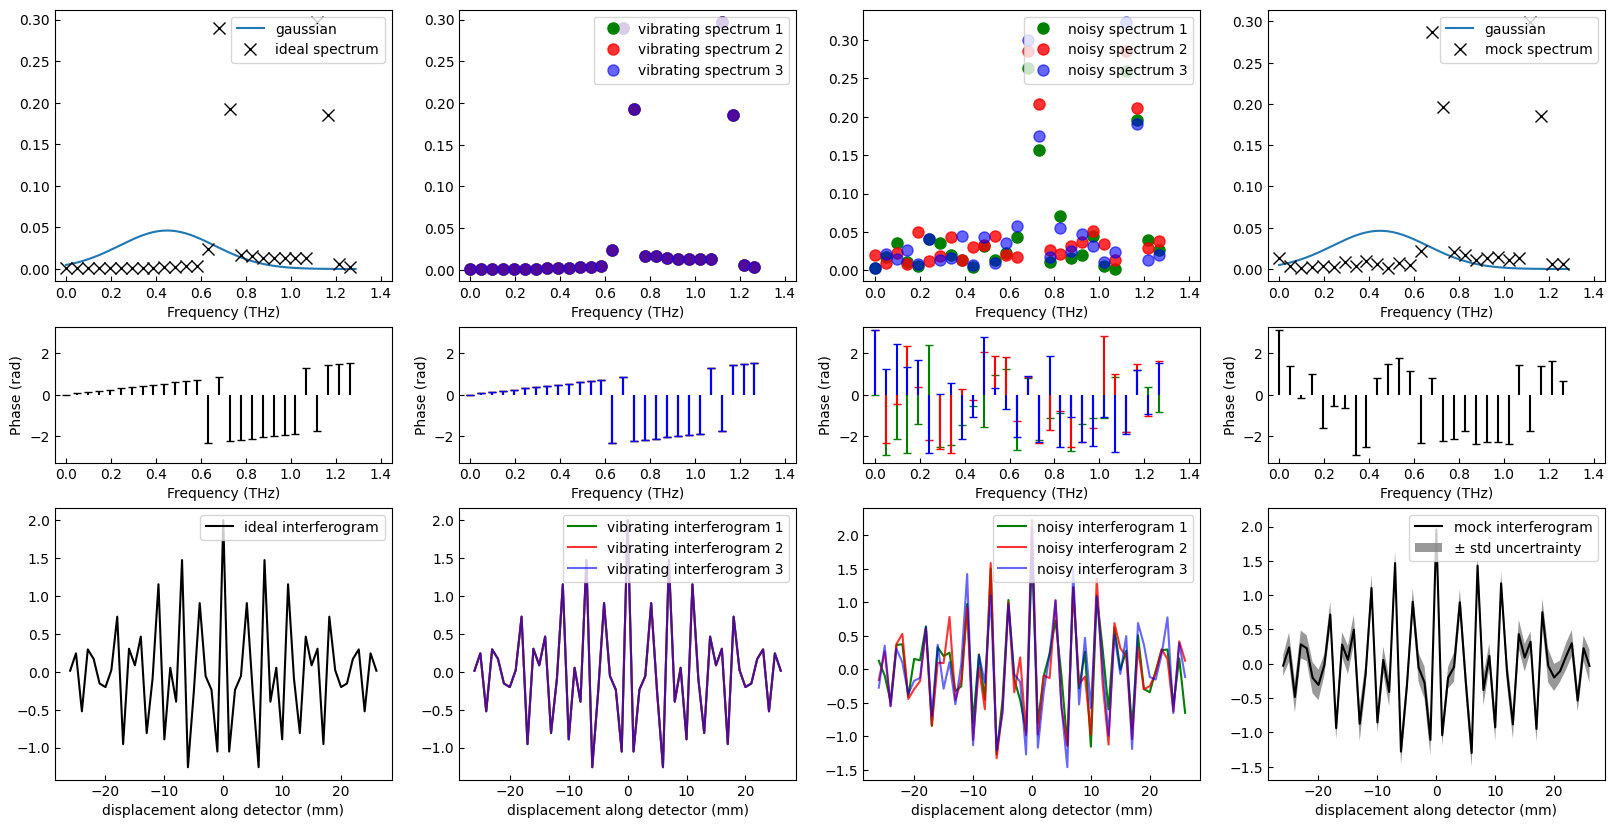

In [224]:
########## MEGACHONKER GRAPH ##############

mosaic = [["spec 1", "spec 2", "spec 3", "spec 4",],
          ["phase 1", "phase 2", "phase 3", "phase 4",],
          ["ifft 1", "ifft 2", "ifft 3", "ifft 4"]]

fig, axs = plt.subplot_mosaic(mosaic, figsize= (20,10), height_ratios= (1, 0.5, 1))

axs["spec 1"].plot(oversampled_freqs, np.abs(oversampled_amps), label= "gaussian")
axs["spec 1"].plot(freqs, np.abs(amplitudes), linestyle= "None", marker= "x", markersize= 8, color= "k", label= "ideal spectrum")
axs["spec 1"].set(xlabel= "Frequency (THz)", xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq))
axs["spec 1"].legend(loc ="upper right")

axs["phase 1"].stem(freqs, np.angle(amplitudes), markerfmt ="k_", basefmt= "None", linefmt= "k")
axs["phase 1"].set(xlabel= "Frequency (THz)", ylabel= "Phase (rad)", xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq), ylim= (-3.3, 3.3))

axs["ifft 1"].plot(displacement, intensity, color= "k", label= "ideal interferogram")
axs["ifft 1"].set(xlabel= "displacement along detector (mm)")
axs["ifft 1"].legend(loc ="upper right")

axs["spec 2"].plot(freqs, np.abs(vibration_amps[0]), linestyle= "None", marker= "o", markersize= 8, color= "green", alpha= 1, label= "vibrating spectrum 1")
axs["spec 2"].plot(freqs, np.abs(vibration_amps[1]), linestyle= "None", marker= "o", markersize= 8, color= "red", alpha= 0.8, label= "vibrating spectrum 2")
axs["spec 2"].plot(freqs, np.abs(vibration_amps[2]), linestyle= "None", marker= "o", markersize= 8, color= "blue", alpha= 0.6, label= "vibrating spectrum 3")
axs["spec 2"].set(xlabel= "Frequency (THz)", xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq))
axs["spec 2"].legend(loc ="upper right")

axs["phase 2"].stem(freqs, np.angle(vibration_amps[0]), markerfmt ="g_", basefmt= "None", linefmt= "g")
axs["phase 2"].stem(freqs, np.angle(vibration_amps[1]), markerfmt ="r_", basefmt= "None", linefmt= "r")
axs["phase 2"].stem(freqs, np.angle(vibration_amps[2]), markerfmt ="b_", basefmt= "None", linefmt= "b")
axs["phase 2"].set(xlabel= "Frequency (THz)", ylabel= "Phase (rad)", xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq), ylim= (-3.3, 3.3))

axs["ifft 2"].plot(displacement, vibration_intensity[0], color= "green", alpha= 1, label= "vibrating interferogram 1")
axs["ifft 2"].plot(displacement, vibration_intensity[1], color= "red", alpha= 0.8, label= "vibrating interferogram 2")
axs["ifft 2"].plot(displacement, vibration_intensity[2], color= "blue", alpha= 0.6, label= "vibrating interferogram 3")
axs["ifft 2"].set(xlabel= "displacement along detector (mm)")
axs["ifft 2"].legend(loc ="upper right")

axs["spec 3"].plot(freqs, np.abs(noisy_amps[0]), linestyle= "None", marker= "o", markersize= 8, color= "green", alpha= 1, label= "noisy spectrum 1")
axs["spec 3"].plot(freqs, np.abs(noisy_amps[1]), linestyle= "None", marker= "o", markersize= 8, color= "red", alpha= 0.8, label= "noisy spectrum 2")
axs["spec 3"].plot(freqs, np.abs(noisy_amps[2]), linestyle= "None", marker= "o", markersize= 8, color= "blue", alpha= 0.6, label= "noisy spectrum 3")
axs["spec 3"].set(xlabel= "Frequency (THz)", xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq))
axs["spec 3"].legend(loc ="upper right")

axs["phase 3"].stem(freqs, np.angle(noisy_amps[0]), markerfmt ="g_", basefmt= "None", linefmt= "g")
axs["phase 3"].stem(freqs, np.angle(noisy_amps[1]), markerfmt ="r_", basefmt= "None", linefmt= "r")
axs["phase 3"].stem(freqs, np.angle(noisy_amps[2]), markerfmt ="b_", basefmt= "None", linefmt= "b")
axs["phase 3"].set(xlabel= "Frequency (THz)", ylabel= "Phase (rad)", xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq), ylim= (-3.3, 3.3))

axs["ifft 3"].plot(displacement, noisy_intensity[0], color= "green", alpha= 1, label= "noisy interferogram 1")
axs["ifft 3"].plot(displacement, noisy_intensity[1], color= "red", alpha= 0.8, label= "noisy interferogram 2")
axs["ifft 3"].plot(displacement, noisy_intensity[2], color= "blue", alpha= 0.6, label= "noisy interferogram 3")
axs["ifft 3"].set(xlabel= "displacement along detector (mm)")
axs["ifft 3"].legend(loc ="upper right")

axs["spec 4"].plot(oversampled_freqs, np.abs(oversampled_amps), label= "gaussian")
axs["spec 4"].plot(freqs, np.abs(averaged_amps), linestyle= "None", marker= "x", markersize= 8, color= "k", label= "mock spectrum")
axs["spec 4"].set(xlabel= "Frequency (THz)", xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq))
axs["spec 4"].legend(loc ="upper right")

axs["phase 4"].stem(freqs, np.angle(averaged_amps), markerfmt ="k_", basefmt= "None", linefmt= "k")
axs["phase 4"].set(xlabel= "Frequency (THz)", ylabel= "Phase (rad)", xlim= (central_freq-FWHM_freq, central_freq+2*FWHM_freq), ylim= (-3.3, 3.3))

axs["ifft 4"].plot(displacement, averaged_intensity, color= "k", label= "mock interferogram")
axs["ifft 4"].set(xlabel= "displacement along detector (mm)")
axs["ifft 4"].fill_between(displacement, averaged_intensity-uncertainty, averaged_intensity+uncertainty, facecolor= "gray", alpha= 0.8, label= "± std uncertrainty")
axs["ifft 4"].legend(loc ="upper right")

plt.show()

In [205]:
########### SAVE AN INTERFEROGRAM FOR TESTING #############

if np.all(uncertainty == 0): uncertainty = np.ones_like(uncertainty)

to_save = np.array([averaged_intensity, uncertainty]).T
#np.savetxt("data\\1dmockanderrors18.csv", to_save, delimiter=",")

In [206]:
def generate_interferogram(array_length, pixel_pitch, central_freq, FWHM_freq, theta, number_of_averages= 30, vibration_uncertainty= 0, read_noise_sigma= 0):
    
    central_wavenumber = 2*np.sin(np.deg2rad(theta/60)) *(central_freq*1e12) /C #periodicity of the fringes as it appears on the camera in m^-1
    FWHM_wavenumber = 2*np.sin(np.deg2rad(theta/60)) *(FWHM_freq*1e12) /C # in m^-1

    wavenumbers = np.fft.rfftfreq(array_length, (pixel_pitch*1e-6))
    freqs = C *wavenumbers /(2*np.sin(np.deg2rad(theta/60))) *1e-12 #in THz
    amplitudes, normalisation_coeffient = gaussian(wavenumbers, central_wavenumber, FWHM_wavenumber)

    temporal_sigma = vibration_uncertainty*1e-3 *2*np.sin(np.deg2rad(theta/60)) /C # convert to s.
    noise = np.random.normal(0, temporal_sigma, number_of_averages)

    vibration_amps = np.repeat(amplitudes[None, :], number_of_averages, axis= 0)
    vibration_amps = (vibration_amps *np.exp(1j *freqs[None, :]*1e12 *noise[:, None]))

    vibration_intensity = np.fft.irfft(vibration_amps, norm= "forward", axis= 1)

    noise = np.random.normal(0, read_noise_sigma, (number_of_averages, array_length))
    noisy_intensity = vibration_intensity +noise

    uncertainty = np.std(noisy_intensity, axis= 0)
    interferogram = np.mean(noisy_intensity, axis= 0)

    interferogram = np.fft.fftshift(interferogram)
    uncertainty = np.fft.fftshift(uncertainty)
    if np.all(uncertainty == 0): uncertainty = np.ones_like(uncertainty)

    return np.array([interferogram, uncertainty]).T

######### SAVE MANY INTERFEROGRAMS FOR TRAINING #########

array_length = 200 #in pixels
pixel_pitch = 200 #in um
central_freqs = np.linspace(2, 4, 30) #[0.1,0.2,0.5,1,2,5,10]
FWHM_freqs = np.linspace(0.5, 2, 30) #[0.1,0.2,0.5,1,2,5,10]
theta = 60
read_noise = 0.2

n = 0
for central_freq in central_freqs:
    for FWHM_freq in FWHM_freqs:
        np.savetxt("data\\training_set6\\interferogram_{0:d}.csv".format(n),
                   generate_interferogram(array_length, pixel_pitch, central_freq, FWHM_freq, theta, read_noise_sigma= read_noise),
                   delimiter=",")
        n += 1

FileNotFoundError: [Errno 2] No such file or directory: 'data\\training_set6\\interferogram_0.csv'